# 1D Basis Functions and DOFs

There are 6 NODE_TYPE's in NGSolve:
- CELL - In 1-D, the number of CELL dofs associated with a node is one less than the order of the space
- EDGE - In 1-D, there are **no** EDGE dofs
- ELEMENT - It seems that in 1-D, 2-D and 3-D, there are **no** ELEMENT dofs (I'm not sure what this type is for).
- FACE - In 1-D, there are **no** FACE dofs
- FACET - In 1-D, the facets are simply vertices.
- VERTEX - In 1-D, the number of VERTEX dofs per vertex is always 1

A node number in NGSolve corresponds to a vertex.  For example, a 1-D mesh with 10 elements has node numbers 0-10 corresponding to the 11 vertices.

A NodeId is a simple structure containing a node number and a NODE_TYPE it refers to a particular vertex, edge, face or cell node in the mesh.

There seems to be no correlation between the node numbers for different types of nodes

We can get the unique NodeId associated with a node number and NODE_TYPE simply by constructing it ```NodeId(NODE_TYPE, node_number)```.  

If the specified type doesn't make sense for the node number, the type field for the NodeId may be undefined, so for example in a 1-D $H^1$ or $L_2$ space, 
```nid = NodeId(ELEMENT,0); print(nid)``` will show e.g. 'undef0', even though print(nid.type) shows NODE_TYPE.ELEMENT.  If you ask for an NodId's ELEMENT dofs anyway, you get a MemoryError: std::bad_array_new_length 

In other cases, a reasonable looking NodeId will be returned even though it doesn't point to any real data.  An example is: print(NodeId(VERTEX,1000)), which displays V1000 (even though there are only 10 vertices!).  Another example is: print(NodeId(FACE,0)), which displays F0 (even though there are no FACE node types in 1-D!).  The same goes for EDGE.

If fes.ndof = 11, print(NodeId(CELL,10)) gives 'C10', but if we try to access dofs for it we get: MemoryError: std::bad_array_new_length.

In 1-D, FACETs correspond to VERTEXs

### Compare with 2-D and 3-D (c.f. HCurlDiv notebook):  

For a 2-D vertex, we have 1 VERTEX dof, p-1 EDGE dofs, (p-1)(p-2)/2 FACE dofs and (p-1)(p-2)/2 CELL dofs (except for the first vertex (node 0), FACE dofs correspond to CELL dofs), although they are numbered independently.  If you ask for the NodeId with type ELEMENT, you still get undef, but if you then ask for its dofs anyway, you get the FACE dofs. In 2-D, FACETs correspond to EDGEs.

For a 3-D vertex, we have 1 VERTEX dof, p-1 EDGE dofs, (p-1)(p-2)/2 FACE dofs  and (p-1)(p-2)/2 CELL dofs (FACE dofs **do not** correspond to CELL dofs).  If you ask for the NodeId with type ELEMENT, you still get undef, but if you then ask for its dofs anyway, you get the CELL dofs.  In 3-D, FACETs correspond to FACEs

In [1]:
from ngsolve import *
import mesh_util
from numpy import linspace
from matplotlib import pyplot as plt
m = mesh_util.uniform_1d_mesh()

Generate a higher order $H^1$ space. We first explore its different types of basis functions.

In [ ]:
mesh = Mesh(m)
order=5
fes = H1(mesh, order=order)
gfu = GridFunction(fes)

The first #vertices basis functions are hat-functions. By setting the solution vector to a unit-vector, we may look at the individual basis functions:

In [4]:
def plot_gf(gfu):
    xs = linspace(0,1,500)
    us = [gfu(x) for x in xs]
    plt.plot(xs,us)


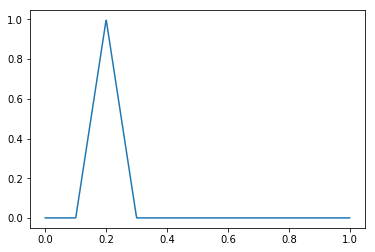

In [5]:
gfu.vec[:] = 0
gfu.vec[2] = 1
plot_gf(gfu)


In [6]:
v = NodeId(VERTEX,2)
print(mesh[v].edges)
c = NodeId(CELL,2)
print(c)
print(fes.GetDofNrs(c))
mv = mesh[v]
# We can get DofNrs for a cell, but not for an edge
# We can get the edges for a vertex, but can't get its cells.
# Maybe not a big deal, because in the 1-D case we can see that
# that cell_j is between vertex_j and vertex_{j+1} for j >= 0.

(E1, E2)
C2
(19, 20, 21, 22)


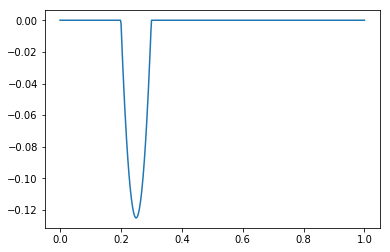

In [7]:
gfu.vec[:] = 0
gfu.vec[19] = 1
plot_gf(gfu)


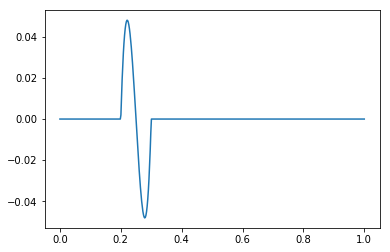

In [8]:
gfu.vec[:] = 0
gfu.vec[20] = 1
plot_gf(gfu)


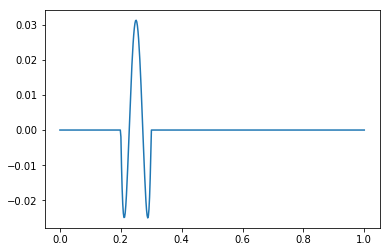

In [9]:
gfu.vec[:] = 0
gfu.vec[21] = 1
plot_gf(gfu)


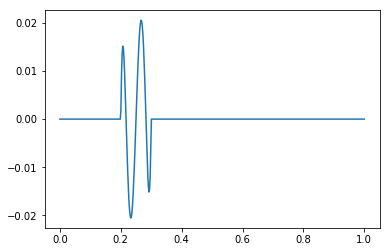

In [10]:
gfu.vec[:] = 0
gfu.vec[22] = 1
plot_gf(gfu)


In [11]:
# Wirebasket DOFs correspond to vertices
# Local DOFs correspond to elements (cells or edges)
# There are no Interface DOFs
for i in range(fes.ndof):
    print (i,":", fes.CouplingType(i))

0 : COUPLING_TYPE.WIREBASKET_DOF
1 : COUPLING_TYPE.WIREBASKET_DOF
2 : COUPLING_TYPE.WIREBASKET_DOF
3 : COUPLING_TYPE.WIREBASKET_DOF
4 : COUPLING_TYPE.WIREBASKET_DOF
5 : COUPLING_TYPE.WIREBASKET_DOF
6 : COUPLING_TYPE.WIREBASKET_DOF
7 : COUPLING_TYPE.WIREBASKET_DOF
8 : COUPLING_TYPE.WIREBASKET_DOF
9 : COUPLING_TYPE.WIREBASKET_DOF
10 : COUPLING_TYPE.WIREBASKET_DOF
11 : COUPLING_TYPE.LOCAL_DOF
12 : COUPLING_TYPE.LOCAL_DOF
13 : COUPLING_TYPE.LOCAL_DOF
14 : COUPLING_TYPE.LOCAL_DOF
15 : COUPLING_TYPE.LOCAL_DOF
16 : COUPLING_TYPE.LOCAL_DOF
17 : COUPLING_TYPE.LOCAL_DOF
18 : COUPLING_TYPE.LOCAL_DOF
19 : COUPLING_TYPE.LOCAL_DOF
20 : COUPLING_TYPE.LOCAL_DOF
21 : COUPLING_TYPE.LOCAL_DOF
22 : COUPLING_TYPE.LOCAL_DOF
23 : COUPLING_TYPE.LOCAL_DOF
24 : COUPLING_TYPE.LOCAL_DOF
25 : COUPLING_TYPE.LOCAL_DOF
26 : COUPLING_TYPE.LOCAL_DOF
27 : COUPLING_TYPE.LOCAL_DOF
28 : COUPLING_TYPE.LOCAL_DOF
29 : COUPLING_TYPE.LOCAL_DOF
30 : COUPLING_TYPE.LOCAL_DOF
31 : COUPLING_TYPE.LOCAL_DOF
32 : COUPLING_TYPE.LOCAL_DO

## 2-D Comparison

In [28]:
import netgen.gui
import time
from numpy import linspace
%gui tk
from ngsolve import *
from netgen.geom2d import unit_square
mesh = Mesh(unit_square.GenerateMesh(maxh=0.3))
fes2 = H1(mesh, order=5)
gfu2 = GridFunction(fes2,'gfu2')
Draw(gfu2)

In [8]:
# At some point, add these to a utility module
def faces_for_vertex(v):
    """We can't just do mesh[v].faces - not supported"""
    fs = []
    for f in mesh.faces:
        if v in mesh[f].vertices:
            fs.append(f)
    return fs

def edges_for_vertex(v):
    """Return only edges that actually touch the vertex""" 
    return [e for e in mesh[v].edges if v in mesh[e].vertices]

def range_for_gf(gf,pts):
    """Given a grid function and a set of points representing vertices
       Evaluate the grid function on a mesh of a rectangular region containing
       the points to find its max and min values in the region""" 
    xs, ys = list(zip(*pts))
    minx, maxx = min(xs), max(xs)
    miny, maxy = min(ys), max(ys)
    minu = 10000
    maxu = -10000
    for x in linspace(minx,maxx,100):
        for y in linspace(miny,maxy,100):
            u = gf(x,y,0)
            if u > maxu: maxu = u
            if u < minu: minu = u
    return minu, maxu

In [9]:
# Note: mesh.ne gives number of elements not number of edges
print("vertices: {}, edges: {}, faces: {}".format(mesh.nv, mesh.nedge, mesh.nface))

vertices: 24, edges: 53, faces: 30


In [10]:
v = NodeId(VERTEX, 17)
fs = faces_for_vertex(v)
print(fs)

[F7, F8, F10, F23, F25]


In [11]:
print(mesh[v].edges)

(E12, E13, E14, E16, E17, E39, E41, E42, E43, E45)


In [26]:
def draw_vertex_shape(fes, gf, v):
    dofs = fes.GetDofNrs(v)
    if dofs:
        d = dofs[0]
        SetVisualization(min=0.0, max=1.0)
        gf.vec[:] = 0
        Draw(gf)
        time.sleep(2)
        gf.vec[d] = 1
    Redraw()
    time.sleep(2)
    for f in faces_for_vertex(v):
        fpts = [mesh[v].point for v in mesh[f].vertices]
        i = 1
        for d in fes.GetDofNrs(f):
            gf.vec[:] = 0
            gf.vec[d] = 1
            minu, maxu = range_for_gf(gf, fpts)
            SetVisualization(min=minu, max=maxu)
            i += 1
            Redraw()
            time.sleep(2)
    for e in edges_for_vertex(v):
        epts = [mesh[v].point for v in mesh[e].vertices]
        i = 1
        for d in fes.GetDofNrs(e):
            gf.vec[:] = 0
            gf.vec[d] = 1
            minu, maxu = range_for_gf(gf, epts)
            SetVisualization(min=minu, max=maxu)
            i += 1
            Redraw()
            time.sleep(2)


In [29]:
draw_vertex_shape(fes2, gfu2, v)

In [13]:
fpts

[(0.49999999999999, 0.0),
 (0.7499999999999949, 0.0),
 (0.5670776673945965, 0.2258448963055964)]

In [16]:
xs, ys = list(zip(*fpts))
minx, maxx = min(xs), max(xs)
miny, maxy = min(ys), max(ys)
print((minx,miny),(maxx,maxy))
minu = 10000
maxu = -10000
for x in linspace(minx,maxx,100):
    for y in linspace(miny,maxy,100):
        u = gfu2(x,y,0)
        if u > maxu: maxu = u
        if u < minu: minu = u
print(minu, maxu)

(0.49999999999999, 0.0) (0.7499999999999949, 0.2258448963055964)
-1.3865044201012057e-17 0.037036314578393535


In [ ]:
for i in range(fes2.ndof):
    print (i,":", fes2.CouplingType(i))

In [8]:
# Wirebasket DOFs correspond to vertices in 2D
for v in mesh.vertices:
    print(fes2.GetDofNrs(v))

(0,)
(1,)
(2,)
(3,)
(4,)
(5,)
(6,)
(7,)
(8,)
(9,)
(10,)
(11,)
(12,)
(13,)
(14,)
(15,)
(16,)
(17,)
(18,)
(19,)
(20,)
(21,)
(22,)
(23,)


In [9]:
# Interface DOFs correspond to edges in 2D
for e in mesh.edges:
    print(fes2.GetDofNrs(e))

(24, 25, 26, 27)
(28, 29, 30, 31)
(32, 33, 34, 35)
(36, 37, 38, 39)
(40, 41, 42, 43)
(44, 45, 46, 47)
(48, 49, 50, 51)
(52, 53, 54, 55)
(56, 57, 58, 59)
(60, 61, 62, 63)
(64, 65, 66, 67)
(68, 69, 70, 71)
(72, 73, 74, 75)
(76, 77, 78, 79)
(80, 81, 82, 83)
(84, 85, 86, 87)
(88, 89, 90, 91)
(92, 93, 94, 95)
(96, 97, 98, 99)
(100, 101, 102, 103)
(104, 105, 106, 107)
(108, 109, 110, 111)
(112, 113, 114, 115)
(116, 117, 118, 119)
(120, 121, 122, 123)
(124, 125, 126, 127)
(128, 129, 130, 131)
(132, 133, 134, 135)
(136, 137, 138, 139)
(140, 141, 142, 143)
(144, 145, 146, 147)
(148, 149, 150, 151)
(152, 153, 154, 155)
(156, 157, 158, 159)
(160, 161, 162, 163)
(164, 165, 166, 167)
(168, 169, 170, 171)
(172, 173, 174, 175)
(176, 177, 178, 179)
(180, 181, 182, 183)
(184, 185, 186, 187)
(188, 189, 190, 191)
(192, 193, 194, 195)
(196, 197, 198, 199)
(200, 201, 202, 203)
(204, 205, 206, 207)
(208, 209, 210, 211)
(212, 213, 214, 215)
(216, 217, 218, 219)
(220, 221, 222, 223)
(224, 225, 226, 227)
(228,

In [10]:
# Local DOFs correspond to elements (faces) in 2D
for f in mesh.faces:
    print(fes2.GetDofNrs(f))

(236, 237, 238, 239, 240, 241)
(260, 261, 262, 263, 264, 265)
(338, 339, 340, 341, 342, 343)
(284, 285, 286, 287, 288, 289)
(308, 309, 310, 311, 312, 313)
(242, 243, 244, 245, 246, 247)
(326, 327, 328, 329, 330, 331)
(248, 249, 250, 251, 252, 253)
(254, 255, 256, 257, 258, 259)
(332, 333, 334, 335, 336, 337)
(386, 387, 388, 389, 390, 391)
(266, 267, 268, 269, 270, 271)
(272, 273, 274, 275, 276, 277)
(278, 279, 280, 281, 282, 283)
(362, 363, 364, 365, 366, 367)
(290, 291, 292, 293, 294, 295)
(296, 297, 298, 299, 300, 301)
(302, 303, 304, 305, 306, 307)
(344, 345, 346, 347, 348, 349)
(374, 375, 376, 377, 378, 379)
(314, 315, 316, 317, 318, 319)
(320, 321, 322, 323, 324, 325)
(350, 351, 352, 353, 354, 355)
(356, 357, 358, 359, 360, 361)
(398, 399, 400, 401, 402, 403)
(392, 393, 394, 395, 396, 397)
(368, 369, 370, 371, 372, 373)
(404, 405, 406, 407, 408, 409)
(380, 381, 382, 383, 384, 385)
(410, 411, 412, 413, 414, 415)
